# <br>[ LG전자_DX_Intensive_Course  ] 딥러닝 기반 시계열 분석 5<br><br> : Deep Auto-Encoder - Recurrent Auto-Encoder<br>

In [ ]:
# github에서 데이터 불러오기
!git clone https://github.com/KU-DIC/LG_time_series_day12.git

In [1]:
# 모듈 불러오기
import os
import time
import copy
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim

# <br>0. Hyperparameter Setting
- batch_size: 학습 및 검증에 사용할 배치의 크기
- num_epochs: 학습할 epoch 횟수
- window_size: input의 시간 길이 (time series data에서 도출한 subsequence의 길이)
- input_size: 변수 개수
- hidden_size: 모델의 hidden dimension
- num_layers: 모델의 layer 개수
- random_seed: reproduction을 위해 고정할 seed의 값

In [2]:
# Hyperparameter setting
batch_size = 32
num_epochs = 20
window_size = 5
input_size = 4
hidden_size = 2
num_layers = 1

random_seed = 42
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Detect if we have a GPU available

In [3]:
# seed 고정
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

---

# <br>__1. Data: NASA Bearing Dataset__
- 데이터 description <br>
    - NASA Bearing Dataset은 NSF I/UCR Center의 Intelligent Maintenance System의 4개의 bearing에서 고장이 발생할 때까지 10분 단위로 수집된 센서 데이터이다. 본 데이터셋은 특정 구간에서 기록된 1-second vibration signal snapshots을 나타내는 여러 개의 파일로 구성되어 있다. 각 파일은 20 kHz 단위로 샘플링 된 20,480개의 data point를 포함하고 있으며, 각 파일의 이름은 데이터가 수집된 시간을 의미한다. 해당 데이터셋은 크게 3개의 데이터를 포함하고 있으며, 본 실습에서 사용하는 데이터는 bearing 1에서 outer race failure가 발생할 때까지 수집된 센서 데이터이다. <br><br>
- 변수 설명
    - 독립 변수 (4개): Bearing1, Bearing2, Bearing3, Bearing4 
    - **종속 변수 (1개): anomaly -> custom label: normal(0) / abnormal(1)** <br><br>
- 출처: https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/

<img src="https://i.imgur.com/dfFzn3H.jpg" width="600">

### Step 1-1. 데이터 불러오기

In [4]:
# 데이터 불러오기
data = pd.read_csv('/content/LG_time_series_day12/input/nasa-data/nasa_bearing_dataset.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,anomaly,data_type
2004-02-12 10:32:39,0.058332,0.071832,0.083244,0.043065,0,train
2004-02-12 10:42:39,0.058997,0.074008,0.084439,0.044540,0,train
2004-02-12 10:52:39,0.060239,0.074223,0.083922,0.044442,0,train
2004-02-12 11:02:39,0.061453,0.073843,0.084462,0.045081,0,train
2004-02-12 11:12:39,0.061361,0.075606,0.082837,0.045118,0,train


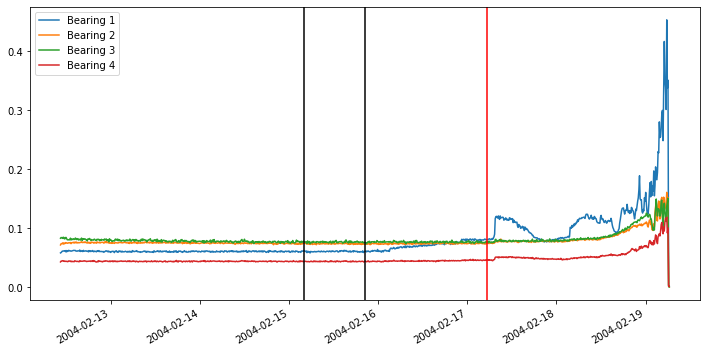

In [5]:
# 전체 기간의 데이터 분포 확인
data.iloc[:, :4].plot(figsize = (12, 6))
plt.axvline(data.index[list(data['data_type']).index('valid')], c='black')  # validation data 시작 위치 표시
plt.axvline(data.index[list(data['data_type']).index('test')], c='black')  # test data 시작 위치 표시
plt.axvline(data.index[list(data['anomaly']).index(1)], c='red')  # abnormal data 시작 위치 표시

### Step 1-2. 데이터 Split

In [6]:
X_train = data[data['data_type'] == 'train'].iloc[:, :4]
y_train = data[data['data_type'] == 'train'].iloc[:, -2].values

X_valid = data[data['data_type'] == 'valid'].iloc[:, :4]
y_valid = data[data['data_type'] == 'valid'].iloc[:, -2].values

X_test = data[data['data_type'] == 'test'].iloc[:, :4]
y_test = data[data['data_type'] == 'test'].iloc[:, -2].values

print("Train data shape:", X_train.shape)
print("Validation data shape:", X_valid.shape)
print("Test data shape:", X_test.shape)

Train data shape: (393, 4)
Validation data shape: (98, 4)
Test data shape: (493, 4)


### Step 1-3. 데이터 정규화

In [7]:
# train 데이터를 기반으로 train/test 데이터에 대하여 min-max scaling 적용 
scaler = MinMaxScaler()
scaler = scaler.fit(X_train)

In [8]:
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

### Step 1-4. DataLoader 구축

In [9]:
class CustomDataset(torch.utils.data.Dataset): 
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
        self.start_point = range(0, len(data) - seq_len)

    # 총 데이터의 개수를 리턴
    def __len__(self): 
        return len(self.start_point)

    # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[self.start_point[idx]:self.start_point[idx] + self.seq_len]) # shape: (seq_len, n_features)
        x = torch.transpose(x, 1, 0) # shape: (n_features, seq_len)
        return x

In [10]:
train_dataset = CustomDataset(X_train, window_size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = CustomDataset(X_valid, window_size)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

test_dataset = CustomDataset(X_test, window_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

---

# <br>__2. Model: Recurrent Auto-Encoder__

### Recurrent Auto-Encoder
>입력과 출력이 동일한 인공신경망 구조 <br>
>정상 데이터에 대한 학습이 충분히 되어 있을 경우 정상 데이터는 자기 자신을 잘 복원할 수 있지만, 이상치 제이터는 학습 기회가 적어 상대적으로 잘 복원하지 못할 것을 가정

<img src="https://i.imgur.com/KpyS57D.jpg" width="700">

In [11]:
class RAE(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_len):
        super(RAE, self).__init__()
        self.seq_len = seq_len
        
        self.encoder = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first=True
        )
        self.decoder = nn.LSTM(
            input_size = hidden_size,
            hidden_size = 2 * hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.fc = nn.Linear(2 * hidden_size, input_size)
                
    def forward(self, x):
        # data dimension: (batch_size x input_size x seq_len) -> (batch_size x seq_len x input_size)로 변환
        x = torch.transpose(x, 1, 2)
        
        enc_x, (enc_hidden_state, enc_cell_state) = self.encoder(x)
        enc_last_hidden = enc_hidden_state[-1, :, :]
        
        enc_last_hidden = enc_last_hidden.unsqueeze(1).repeat(1, self.seq_len, 1)
        dec_x, (dec_hidden_state, dec_cell_state) = self.decoder(enc_last_hidden)
        dec_x = dec_x.reshape((x.size(0), self.seq_len, -1))
        
        out = self.fc(dec_x)
        out = torch.sigmoid(out)
        out = torch.transpose(out, 1, 2)
        return out

In [12]:
# RAE 모델 구축
model = RAE(input_size, hidden_size, num_layers, seq_len=window_size)
model = model.to(device)
print(model)

RAE(
  (encoder): LSTM(4, 2, batch_first=True)
  (decoder): LSTM(2, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=4, bias=True)
)


---

# <br>__3. Training__

In [13]:
def train_model(model, dataloaders, criterion, num_epochs, optimizer):
    since = time.time()

    val_mse_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_mse = 10000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # 각 epoch마다 순서대로 training과 validation을 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 training mode로 설정
            else:
                model.eval()   # 모델을 validation mode로 설정

            running_loss = 0.0
            running_total = 0

            # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
            for inputs in dataloaders[phase]:
                inputs = inputs.to(device)

                # parameter gradients를 0으로 설정
                optimizer.zero_grad()

                # forward
                # training 단계에서만 gradient 업데이트 수행
                with torch.set_grad_enabled(phase == 'train'):
                    # input을 model에 넣어 output을 도출한 후, loss를 계산함
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)

                    # backward (optimize): training 단계에서만 수행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # batch별 loss를 축적함
                running_loss += loss.item() * inputs.size(0)
                running_total += inputs.size(0)

            # epoch의 loss 및 RMSE 도출
            epoch_loss = running_loss / running_total

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
            if phase == 'val' and epoch_loss < best_mse:
                best_mse = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_mse_history.append(epoch_loss)

        print()

    # 전체 학습 시간 계산
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val MSE: {:4f}'.format(best_mse))

    # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
    model.load_state_dict(best_model_wts)
    
    # best model 가중치 저장
    # torch.save(best_model_wts, '../output/best_model.pt')
    return model, val_mse_history

In [14]:
# trining 단계에서 사용할 Dataloader dictionary 생성
dataloaders_dict = {
    'train': train_loader,
    'val': valid_loader
}

In [15]:
# loss function 설정
criterion = nn.MSELoss()

In [16]:
# RAE 모델 학습
model, val_mse_history = train_model(model, dataloaders_dict, criterion, num_epochs,
                                     optimizer=optim.Adam(model.parameters(), lr=0.0001))

Epoch 1/20
----------
train Loss: 0.0378
val Loss: 0.0638

Epoch 2/20
----------
train Loss: 0.0377
val Loss: 0.0636

Epoch 3/20
----------
train Loss: 0.0376
val Loss: 0.0635

Epoch 4/20
----------
train Loss: 0.0375
val Loss: 0.0633

Epoch 5/20
----------
train Loss: 0.0374
val Loss: 0.0631

Epoch 6/20
----------
train Loss: 0.0373
val Loss: 0.0630

Epoch 7/20
----------
train Loss: 0.0372
val Loss: 0.0628

Epoch 8/20
----------
train Loss: 0.0371
val Loss: 0.0626

Epoch 9/20
----------
train Loss: 0.0370
val Loss: 0.0625

Epoch 10/20
----------
train Loss: 0.0369
val Loss: 0.0623

Epoch 11/20
----------
train Loss: 0.0368
val Loss: 0.0622

Epoch 12/20
----------
train Loss: 0.0367
val Loss: 0.0620

Epoch 13/20
----------
train Loss: 0.0366
val Loss: 0.0618

Epoch 14/20
----------
train Loss: 0.0365
val Loss: 0.0617

Epoch 15/20
----------
train Loss: 0.0364
val Loss: 0.0615

Epoch 16/20
----------
train Loss: 0.0363
val Loss: 0.0614

Epoch 17/20
----------
train Loss: 0.0362
val Los

---

# <br>__4. Anomaly Detection__

### Step 4-1. 적합된 모델을 기반으로 train/valid/test 데이터의 anomaly score 도출

In [17]:
def test_model(model, test_loader, criterion):
    model.eval()   # 모델을 validation mode로 설정
    
    # test_loader에 대하여 anomaly score 도출 (gradient update 방지)
    with torch.no_grad():
        test_loss = []
        for inputs in test_loader:
            inputs = inputs.to(device)

            # forward
            # input을 model에 넣어 output을 도출한 후, loss를 계산함
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss = loss.mean(axis=-1).mean(axis=-1)

            # sample별 loss를 축적함
            test_loss += loss.cpu().data.numpy().tolist()
    return test_loss

In [18]:
# loss function 설정하기
ad_criterion = nn.L1Loss(reduction='none')

In [19]:
# train/valid/test 데이터에 대한 최종 결과 도출
train_loss = test_model(model, train_loader, ad_criterion)
valid_loss = test_model(model, valid_loader, ad_criterion)
test_loss = test_model(model, test_loader, ad_criterion)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'Test Data')

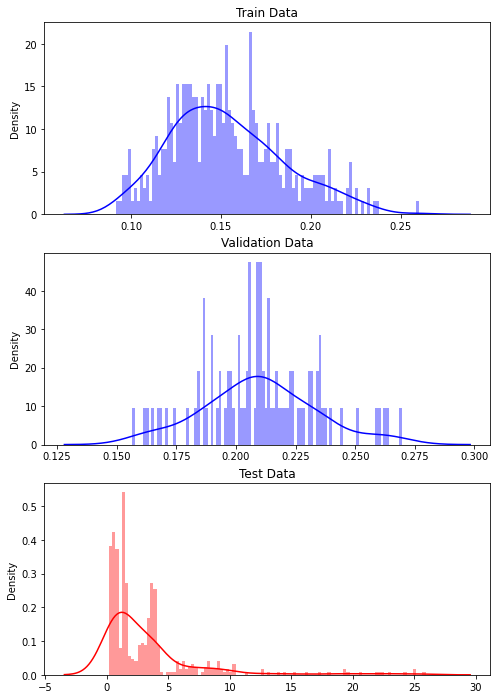

In [20]:
# valid/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize = (8, 12))

sns.distplot(train_loss, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(valid_loss, bins=100, kde=True, color='blue', ax=ax2)
sns.distplot(test_loss, bins=100, kde=True, color='red', ax=ax3)
ax1.set_title("Train Data")
ax2.set_title("Validation Data")
ax3.set_title("Test Data")

### Step 4-2. Threshold 탐색

In [21]:
# threshold 탐색
# score의 min ~ max 범위를 num_step개로 균등 분할한 threshold에 대하여 best threshold 탐색 
def search_best_threshold(score, y_true, num_step):
    best_f1 = 0.5
    best_threshold = None
    for threshold in np.linspace(min(score), max(score), num_step):
        y_pred = threshold < score

        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print('Best threshold: ', round(best_threshold, 4))
    print('Best F1 Score:', round(best_f1, 4))
    return best_threshold

In [22]:
# best threshold 탐색 (Best threshold:  1.2937)
best_threshold = search_best_threshold(test_loss, y_test[window_size:], num_step=1000)

Best threshold:  1.2937
Best F1 Score: 0.9834


### Step 4-3. Best threshold를 기반으로 이상치 탐지 모형 평가 (정량적)

In [23]:
train_dates = data[data['data_type'] == 'train'].index[window_size:]
valid_dates = data[data['data_type'] == 'valid'].index[window_size:]
test_dates = data[data['data_type'] == 'test'].index[window_size:]

In [24]:
scores = pd.DataFrame(index=list(train_dates) + list(valid_dates) + list(test_dates))
scores['score'] = list(np.hstack([train_loss, valid_loss, test_loss]))
scores['anomaly'] = best_threshold < scores['score']
scores.head()

,score,anomaly
2004-02-12 11:22:39,0.131568,False
2004-02-12 11:32:39,0.192033,False
2004-02-12 11:42:39,0.134857,False
2004-02-12 11:52:39,0.151587,False
2004-02-12 12:02:39,0.210760,False


In [25]:
# FRR, FAR, F1 score 도출
def calculate_metric(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    tp, fn, fp, tn = cm.ravel()
    
    frr = fp / (fp + tn)
    far = fn / (fn + tp) 
    
    f1 = f1_score(y_true, y_pred)
    
    return frr, far, f1

In [26]:
# FRR: 0.0521  |  FAR: 0.0  |  F1 Score: 0.9834
frr, far, f1 = calculate_metric(y_test[window_size:], scores['anomaly'][test_dates[0]:])

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}".format(round(frr, 4), round(far, 4), round(f1, 4)))

**  FRR: 0.0521  |  FAR: 0.0  |  F1 Score: 0.9834


### Step 4-4. Best threshold를 기반으로 이상치 탐지 모형 평가 (정성적)

In [27]:
# anomaly score plot 도출
def draw_plot(data, scores, threshold):
    normal_scores = scores[scores['anomaly'] == False]
    abnormal_scores = scores[scores['anomaly'] == True]

    plt.figure(figsize = (12,5))
    plt.scatter(normal_scores.index, normal_scores['score'], label='Normal', c='blue', s=3)
    plt.scatter(abnormal_scores.index, abnormal_scores['score'], label='Abnormal', c='red', s=3)
    
    plt.axhline(threshold, c='green', alpha=0.7)
    plt.axvline(data.index[list(data['data_type']).index('valid')], c='orange', ls='--')  # validation data 시작 위치 표시
    plt.axvline(data.index[list(data['data_type']).index('test')], c='orange', ls='--')  # test data 시작 위치 표시
    
    plt.xlabel('Date')
    plt.ylabel('Anomaly Score')
    plt.legend()
    
    plt.show()

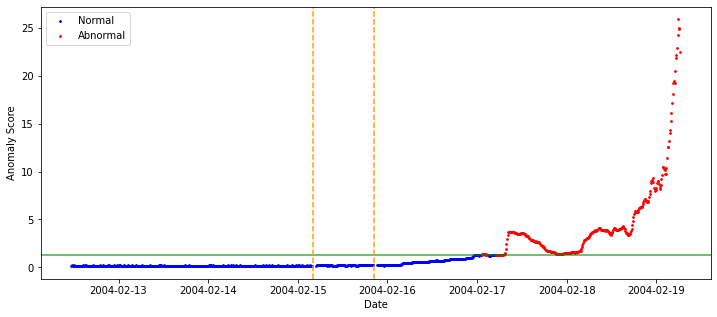

In [28]:
# 전체 기간의 데이터 분포 확인
draw_plot(data, scores, best_threshold)

---